# Setup

**Imports**

In [1]:
import datetime as dt
from math import log
import IPython
import geopandas
import contextily as cx
from math import asin, cos, radians, sin, sqrt


from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from scipy.linalg import eigh
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from scipy.fft import fft
from pygsp import graphs
from scipy.spatial.distance import pdist, squareform

rng = np.random.default_rng()

import seaborn as sns

# Question 1

The following cell loads the training data set `X_train` and `y_train`.
`X_train` is a list of 100 signals; `y_train` is a list of 100 symbol sequences. 

The signals have a varying number of symbols with a varying duration. 
There is a brief silence between each symbol.
The sampling frequency is $22.05 $ kHz.

In [2]:
FS = 22050  # sampling frequency (Hz)

X_train = np.load("X_train.npy", allow_pickle=True).tolist()
y_train = np.load("y_train.npy", allow_pickle=True).tolist()

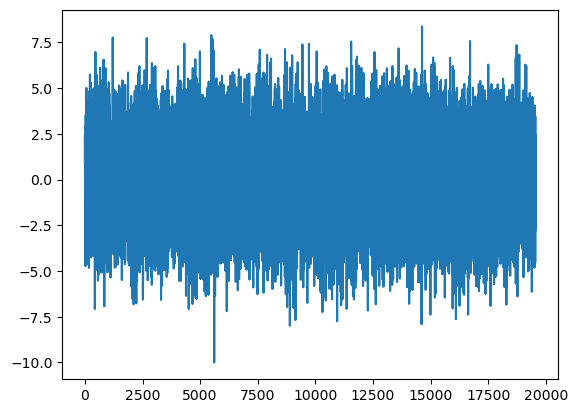

In [3]:
plt.plot(X_train[0])

In [4]:
signal, symbols = X_train[2], y_train[2]
print(" ".join(symbols))
IPython.display.Audio(signal, rate=FS)

D 6 A 8 3 D 1 8 B 9


# Question 2

In [5]:
X_test = np.load("X_test.npy", allow_pickle=True).tolist()

# Question 3

In [2]:
M=9
def gU(lambda_, a, R):
    return np.where((-R*a <= lambda_ ) & (lambda_< 0), 1/2*(1+np.cos(2*np.pi*(lambda_/(a*R) + 1/2))), 0)

def gm_hat(lambda_, m, lambda_max, R):
    a = lambda_max/(M+1-R)
    return gU(lambda_ - a*m, a, R)

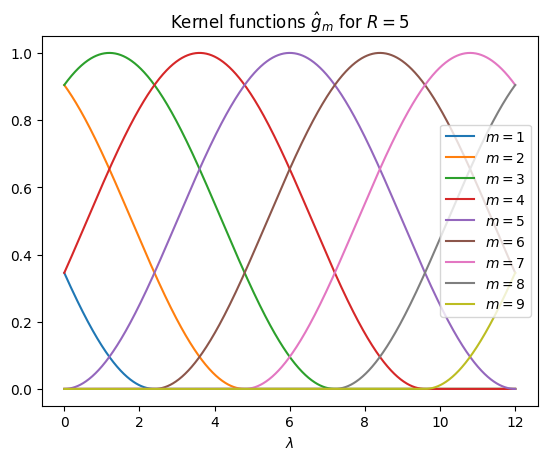

In [3]:
lambda_max = 12
R = 5

lambda_values = np.linspace(0, lambda_max, 1000)
for m in np.arange(1, M+1):
    plt.plot(lambda_values, gm_hat(lambda_values, m, lambda_max, R), label=fr'$m={m}$')

plt.title(fr'Kernel functions $\hat{{g}}_m$ for $R={R}$')
plt.xlabel(r'$\lambda$')
plt.legend()
plt.show()

# Question 4

## Utility functions: 

In [4]:
def dms2dd(s):
    """Convert longitude and latitude strings to float."""
    # https://stackoverflow.com/a/50193328
    # example: s =  """48°51'18"""
    degrees, minutes, seconds = re.split("[°'\"]+", s[:-1])
    direction = s[-1]
    dd = float(degrees) + float(minutes) / 60 + float(seconds) / (60 * 60)
    if direction in ("S", "W"):
        dd *= -1
    return dd

def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r    

def get_exponential_similarity(condensed_distance_matrix, bandwidth, threshold):
    exp_similarity = np.exp(-(condensed_distance_matrix**2) / bandwidth / bandwidth)
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

def is_connected(graph) -> bool:
    return graph.is_connected()

def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [5]:
data_df, stations_df, description = load_molene_meteo_dataset()

In [6]:
data_df["temp"] = data_df['t']- 273.15  # temperature in Celsius
temperature_df = data_df.pivot(index="date", values="temp", columns="station_name")
temperature_df.head()

station_name,ARZAL,AURAY,BATZ,BEG_MEIL,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,CAMARET,DINARD,...,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,TREGUNC,VANNES-MEUCON,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,NaN,NaN,11.3,7.1,9.7,NaN,NaN,6.8,...,7.4,8.5,8.3,7.5,9.0,9.0,9.3,10.8,8.5,9.7
2014-01-01 01:00:00,9.8,10.4,NaN,NaN,10.3,7.6,9.6,9.2,NaN,6.5,...,8.2,8.3,8.6,7.0,9.1,9.5,9.1,10.9,8.7,9.9
2014-01-01 02:00:00,9.7,10.0,NaN,NaN,11.2,7.7,9.1,9.4,NaN,6.5,...,8.5,8.5,8.6,7.5,9.5,9.4,9.4,10.6,8.8,9.6
2014-01-01 03:00:00,9.4,10.4,NaN,NaN,11.4,7.9,9.7,10.1,NaN,7.1,...,8.5,8.7,8.9,7.2,9.0,9.9,8.9,10.8,8.6,9.8
2014-01-01 04:00:00,9.8,10.8,NaN,NaN,11.4,8.8,9.8,10.2,NaN,7.6,...,9.1,9.1,9.4,7.6,9.5,10.0,9.6,11.0,9.2,10.2


In [7]:
missing_values_series = temperature_df.isna().sum(axis=0)

print(f'There are {len(missing_values_series[missing_values_series>0])} stations with at least 1 missing values in the temperature.')
print('The stations with missing values are:')
for station in missing_values_series[missing_values_series>0].index:
    print(station)

There are 18 stations with at least 1 missing values in the temperature.
The stations with missing values are:
ARZAL
BATZ
BEG_MEIL
BREST-GUIPAVAS
BRIGNOGAN
CAMARET
LANDIVISIAU
LANNAERO
LANVEOC
OUESSANT-STIFF
PLOUAY-SA
PLOUDALMEZEAU
PLOUGONVELIN
QUIMPER
RIEC SUR BELON
SIZUN
ST NAZAIRE-MONTOIR
VANNES-MEUCON


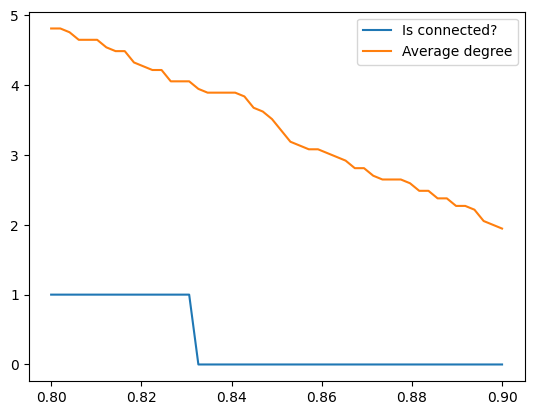

In [58]:
temperature_df_cleaned = temperature_df.dropna(axis=1)  # We remove stations with missing values (There are 37 columns left)
stations_df_cleaned = stations_df.set_index('Nom').loc[temperature_df_cleaned.columns].reset_index() # In the stations dataframe, we also only keep the stations left

# Computation of the distance matrix using the code of the TP3
stations_np = stations_df_cleaned[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)

# Construction of the graph with exponential smoothing using the code of the TP3
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold_values = np.linspace(0.8, 0.9)
connected = []
mean_degree = []
for threshold in threshold_values: 
    adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
    G = graphs.Graph(adjacency_matrix)
    connected.append(is_connected(G))
    mean_degree.append(2*G.Ne/G.N)

plt.plot(threshold_values, np.array(connected, dtype=float), label='Is connected?')
plt.plot(threshold_values, mean_degree, label='Average degree')
plt.legend()
plt.show()


We observe that the threshold is around $0.83$ when the graph becomes connected. For this value, the average degree in the graph is approximately $4$.  

In [59]:
# We verify that 0.83 works 
threshold = 0.83
adjacency_matrix = squareform(get_exponential_similarity(dist_mat_condensed, sigma, threshold))
G = graphs.Graph(adjacency_matrix)

print(
    f"The graph is {'not ' if not is_connected(G) else ''}connected, with {G.N} nodes, {G.Ne} edges. Its average degree is {2*G.Ne/G.N}"
)

The graph is connected, with 37 nodes, 75 edges. Its average degree is 4.054054054054054


In [60]:
# Computing smoothness in the graph over time
smoothness_values_over_time = []
for date in temperature_df_cleaned.index:
    x = temperature_df_cleaned.loc[date].to_numpy()
    L = G.L.todense()
    smoothness_value = float(x.T @ L @ x)
    smoothness_values_over_time.append(smoothness_value)


# Minimum of the smoothness = signal is the smoothest
smoothness_argmin = np.argmin(smoothness_values_over_time)
smoothest_date = temperature_df_cleaned.index[smoothness_argmin]
print('The signal is the smoothest at', smoothest_date)

# Maximum of the smoothness = signal is the least smooth
smoothness_argmax = np.argmax(smoothness_values_over_time)
least_smooth_date = temperature_df_cleaned.index[smoothness_argmax]
print('The signal is the least smooth at', least_smooth_date)

C:\Users\victo\AppData\Local\Temp\ipykernel_20788\1526936048.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  smoothness_value = float(x.T @ L @ x)


The signal is the smoothest at 2014-01-24 23:00:00
The signal is the least smooth at 2014-01-21 03:00:00


# Question 5

In [61]:
R = 3
eigenvals, eigenvects = eigh(G.L.todense())

def GWT(f, m, v):
    """Graph Wavelet Transform of the signal f applied to m, v"""
    f_hat = eigenvects.T @ f # Fourier transform of f
    return np.sum(gm_hat(eigenvals, m, eigenvals[-1], R)*f_hat*eigenvects[v, :]) 


def features_vector(f, v):
    """Compute the vector of features using GWT for node v"""
    return np.array([GWT(f, m, v) for m in range(1, M+1)]) 

In [62]:
# For visualization
CRS = "EPSG:4326"

stations_gdf = geopandas.GeoDataFrame(
    stations_df_cleaned,
    geometry=geopandas.points_from_xy(stations_df_cleaned.Longitude, stations_df_cleaned.Latitude),
).set_crs(CRS)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Index(['AURAY', 'BELLE ILE-LE TALUT', 'BIGNAN', 'DINARD', 'GUERANDE',
       'GUISCRIFF SA', 'ILE DE GROIX', 'ILE-DE-BREHAT', 'KERPERT',
       'LORIENT-LANN BIHOUE', 'LOUARGAT', 'MERDRIGNAC', 'MORLAIX_AERO',
       'NOIRMOUTIER EN', 'PLEUCADEUC', 'PLEYBER-CHRIST SA', 'PLOERMEL',
       'PLOUGUENAST', 'PLOUMANAC'H', 'PLOVAN', 'POMMERIT-JAUDY', 'PONTIVY',
       'PTE DE CHEMOULIN', 'PTE DE PENMARCH', 'PTE DU RAZ', 'QUINTENIC',
       'ROSTRENEN', 'SAINT-CAST-LE-G', 'SAINT-JOACHIM_SAE', 'SARZEAU SA',
       'SIBIRIL S A', 'SPEZET', 'ST BRIEUC', 'ST-SEGAL S A', 'THEIX',
       'TREGUNC', 'VANNES-SENE'],
      dtype='object', name='station_name')
           station_name    Numéro   Latitude  Longitude  \
0                 AURAY  56007001  47.659167  -2.971000   
1    BELLE ILE-LE TALUT  56009001  47.294333  -3.218333   
2                BIGNAN  56017003  47.884333  -2.728833   
3                DINARD  35228001  48

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\pygsp\plotting.py:610: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  sc = ax.scatter(


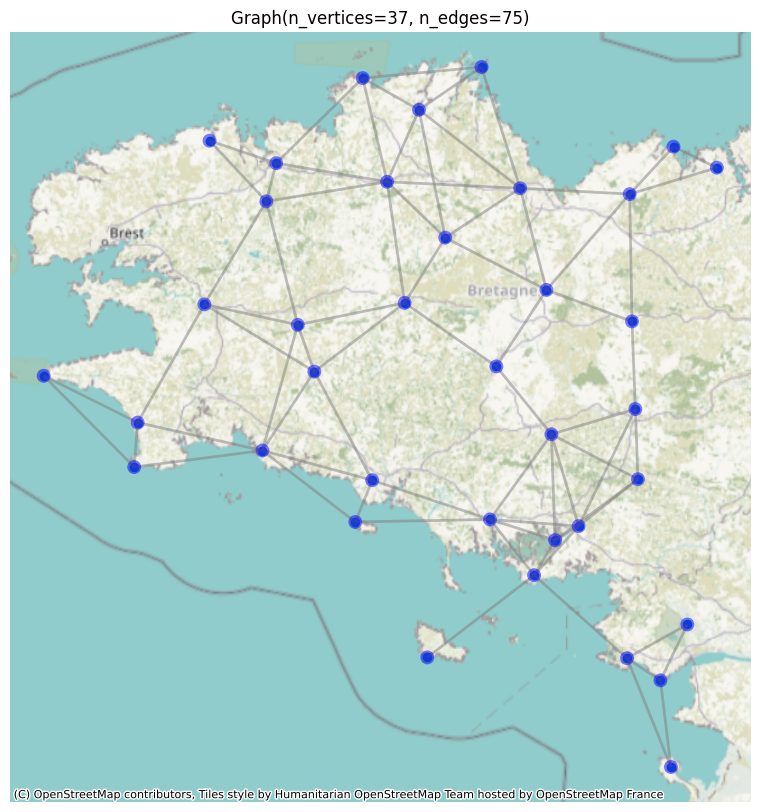

In [ ]:
smoothest_temperature = temperature_df_cleaned.loc[smoothest_date].to_numpy()
least_smooth_temperature = temperature_df_cleaned.loc[least_smooth_date].to_numpy()

n = len(temperature_df_cleaned.columns)
energy_features = np.zeros((n, 3)) # Each row is a node, each line is low/medium/high frequency energy
for v in range(n):
    features = features_vector(smoothest_temperature, v)
    energy_features[v,0] = np.sum(features[:3]**2)
    energy_features[v,1] = np.sum(features[3:6]**2)
    energy_features[v,2] = np.sum(features[6:]**2)

classifications = np.argmax(energy_features, axis=1)

colors = ['blue', 'green', 'red']
labels = ['Low Frequency', 'Medium Frequency', 'High Frequency']
node_colors = [colors[c] for c in classifications]


ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

# Set coordinates for graph nodes
G.set_coordinates(stations_np)

# Plot graph with node colors
G.plot(ax=ax, vertex_color=node_colors, vertex_size=100)
# ax.set_title(f"Smoothest temperature signal on {smoothest_date}")
plt.show()

# Question 6

# Question 7